## Notebook for plotting deployed performance of Chemprop (OOD)

### Target property: Oxidative stability
### Dataset: In-house + Literature OOD

**Modified on 14th March, 2023 (new color scheme+tanimoto similarity); remodified on 30th January, 2024**

In [1]:
# import chemprop
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
import matplotlib
plt.rcParams['font.family'] = 'Arial'
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools
import plotly.express as px
import plotly.graph_objects as go
# import molplotly

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/oxidative-stability_1.1/incl-rdkit-features/hyperparameters_1.1
total 6976
-rw-r--r--@  1 riteshk  staff     6633 Nov 25 19:26 error_vs_tanimoto_ie_ood_112523_1.csv
-rw-------@  1 riteshk  staff   883428 Nov 27 16:37 deploy_parity_plot.ipynb
-rw-------@  1 riteshk  staff     5196 Jan 21 00:40 preds_ood_int-lit_rand_s400_e1.csv
-rw-------@  1 riteshk  staff  1390569 Jan 24 21:09 deploy_parity_plot_incl_lit.ipynb
-rw-------@  1 riteshk  staff     4556 Jan 28 23:38 oxstab_ood_all_mp_level.csv
-rw-r--r--   1 riteshk  staff     6490 Jan 29 00:18 oxstab_ood_all_mp_level_sim_train_radom.csv
-rw-------@  1 riteshk  staff   669890 Jan 29 00:50 deploy_parity_plot_incl_lit_mp_level.ipynb
-rw-------@  1 riteshk  staff     4546 Jan 30 15:04 oxstab_ood_all_mp_level_thf.csv
-rw-------@  1 riteshk  staff   644614 Jan 30 17:46 deploy_parity_plot_incl_lit_mp_level_thf.ipynb
drwxr-xr-x  16 riteshk  staff     

**Performance using random split models**

In [60]:
%%bash
open .

In [2]:
def plot_oxstab_parity(df_pred, figname=None):
    cmap2 = mc.LinearSegmentedColormap.from_list('mycmap', [lighter_color, color])
    norm2 = plt.Normalize(vmin=df_pred["similarity"].min(), vmax=df_pred["similarity"].max())

    axmin = min(min(df_pred['true_IE']), min(df_pred['IE'])) - 0.1*(max(df_pred['true_IE'])-min(df_pred['true_IE']))
    axmax = max(max(df_pred['true_IE']), max(df_pred['IE'])) + 0.1*(max(df_pred['true_IE'])-min(df_pred['true_IE']))

    fig, ax = plt.subplots(1,1)
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    # Define a dictionary to map groups to markers
    group_marker_dict = {group: marker for group, marker in zip(df_pred['group'].unique(), ['o', '^'])}

    # Define a dictionary to map classes to sizes
    class_size_dict = {cls: size for cls, size in zip(df_pred['class'].unique(), [50, 100])}

    # Define a dictionary to map sizes to edgecolors
    size_edgecolor_dict = {size: edgecolor for size, edgecolor in zip([50, 100], ['black', 'red'])}

    # Create a new column 'marker' in df_true based on the 'group' column
    df_pred['marker'] = df_pred['group'].map(group_marker_dict)

    # Create a new column 'size' in df_true based on the 'class' column
    df_pred['size'] = df_pred['class'].map(class_size_dict)
    df_pred['edgecolor'] = df_pred['size'].map(size_edgecolor_dict)

    # Create the scatter plot
    for group, marker in group_marker_dict.items():
        df_group = df_pred[df_pred['group'] == group]
        err = ax.errorbar(df_group['true_IE'], df_pred.loc[df_group.index, 'IE'], yerr=df_group['IE_ensemble_uncal_var'], fmt='none', ecolor=color, elinewidth=0.75, capsize=2, zorder=1)
        sc = ax.scatter(df_group['true_IE'], df_pred.loc[df_group.index, 'IE'], marker=marker, s=df_group['size'], c=df_group["similarity"], cmap=cmap2, norm=norm2, edgecolors='black', linewidths=0.75, zorder=2)

    # Add colorbar, legend, labels, and other elements as before
    # fig.colorbar(err, ax=ax, ticks=[0.25, 0.50, 0.75, 1.00])
    fig.colorbar(sc, ax=ax, ticks=[0.2, 0.4, 0.6, 0.8, 1.0])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('DFT $E_{ox}$ vs Li/Li$^+$ (V)')
    plt.ylabel('ML-predicted $E_{ox}$ vs Li/Li$^+$ (V)')
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    ax.set_aspect('equal')
    at = AnchoredText(
    f"MAE (OOD) = {mae:.2f}\n\nRMSE (OOD) = {rmse:.2f}", prop=dict(size=10), frameon=False, loc='upper left')
    ax.add_artist(at)
    if figname != None:
        plt.savefig(figname, dpi=300)

In [3]:
## model-1 without RDKit molecular features & hyperparameters (higher): "depth": 2, "dropout": 0.0, "ffn_hidden_size": 700, "ffn_num_layers": 3, "hidden_size": 700
df_pred_rand_1 = pd.read_csv('random-split/deploy/ood-int-lit/preds_oxstab_ood_final_rand_e3_s700.csv') 
df_pred_rand_1['group'] = ['in-house' for i in range(29)] + ['literature' for i in range(29, len(df_pred_rand_1))] ## first 29 are in-house, rest are literature OOD data points
df_pred_rand_1

,name,smiles,true_IE,class,IE,IE_ensemble_uncal_var,EA,EA_ensemble_uncal_var,group
0,E2F,FC(F)(F)COCCOCC(F)(F)F,6.259262,Ether,6.902904,0.031232,0.149816,0.096668,in-house
1,E2F2,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,6.277077,Ether,7.166503,0.033651,0.103583,0.047010,in-house
2,E3,CCOCCOCCOCC,5.587656,Ether,5.314456,0.026945,-1.154688,0.133182,in-house
3,E3F,FC(F)(F)COCCOCCOCC(F)(F)F,6.003231,Ether,6.549007,0.031906,0.157509,0.108221,in-house
4,E3F2,FC(F)(F)C(F)(F)COCCOCCOCC(F)(F)C(F)(F)F,6.018283,Ether,6.869249,0.031821,0.138842,0.062992,in-house
5,E4,CCOCCOCCOCCOCC,5.939028,Ether,5.301384,0.032812,-1.112450,0.210833,in-house
6,E4F,FC(F)(F)COCCOCCOCCOCC(F)(F)F,5.757092,Ether,6.334795,0.029736,0.158418,0.119180,in-house
7,E4F2,FC(F)(F)C(F)(F)COCCOCCOCCOCC(F)(F)C(F)(F)F,5.759758,Ether,6.660833,0.029230,0.171031,0.080446,in-house
8,E5,CCOCCOCCOCCOCCOCC,5.916364,Ether,5.284116,0.032032,-1.084511,0.265206,in-house
9,E5F,FC(F)(F)COCCOCCOCCOCCOCC(F)(F)F,5.722913,Ether,6.179468,0.027351,0.139749,0.140600,in-house


In [65]:
# df_all = pd.read_csv('../../final_MP_red4.csv')
# df_all['smiles'] = df_all['smiles'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
# df_all

,smiles,IE,EA
0,CC(C)C#CC(C)C,5.481535,-0.771096
1,O=C=O,9.433272,0.941193
2,O,7.902121,-1.343401
3,C/C=C/C(C)C,5.085723,-1.005246
4,Cc1ccc(C)c(C)c1,4.733493,-0.843508
...,...,...,...
18128,O=C(O)c1cccc2c1N([N+](=O)[O-])SN2,3.220508,3.856206
18129,CC(=O)c1ccc2c(c1C#N)NSN2,3.620069,1.502602
18130,CCN1SNc2cc(Cl)ccc21,3.308856,2.027702
18131,CCc1ccc2c(c1O)NSN2,3.476727,2.415027


In [66]:
# ## find all smiles from df_pred_rand_1 in df_all
# df_all_rand_1 = df_all[df_all['smiles'].isin(df_pred_rand_1['smiles'])]
# df_all_rand_1

,smiles,IE,EA


Check the similarity between OOD and train data

In [4]:
df_ref = pd.read_csv('./random-split/train_random.csv') ## random split train set
ref = df_ref['smiles']
ref_mol = [Chem.MolFromSmiles(sm) for sm in ref]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

def check_similarity(smile):
    mol = Chem.MolFromSmiles(smile)
    mol_fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    similarity = [DataStructs.FingerprintSimilarity(mol_fps, ref) for ref in ref_fps]
    max_similarity = max(similarity)
    ind = similarity.index(max_similarity)
    sim_smile = ref[ind]
    return max_similarity, ind, sim_smile

In [5]:
similarity_list = []
similar_smiles = []
for i in range(len(df_pred_rand_1)):
    sm = df_pred_rand_1['smiles'][i]
    max_similarity, ind, sim_smile = check_similarity(sm)
    # print(sm, max_similarity, sim_smile)
    similarity_list.append(max_similarity)
    similar_smiles.append(sim_smile)
df_pred_rand_1['similarity'] = similarity_list
df_pred_rand_1['most_similar'] = similar_smiles
df_pred_rand_1

,name,smiles,true_IE,class,IE,IE_ensemble_uncal_var,EA,EA_ensemble_uncal_var,group,similarity,most_similar
0,E2F,FC(F)(F)COCCOCC(F)(F)F,6.259262,Ether,6.902904,0.031232,0.149816,0.096668,in-house,0.347826,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F
1,E2F2,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,6.277077,Ether,7.166503,0.033651,0.103583,0.047010,in-house,0.259259,C(COCCO)(COCCO)(COCCO)CC
2,E3,CCOCCOCCOCC,5.587656,Ether,5.314456,0.026945,-1.154688,0.133182,in-house,0.909091,C(COCC)OCC
3,E3F,FC(F)(F)COCCOCCOCC(F)(F)F,6.003231,Ether,6.549007,0.031906,0.157509,0.108221,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F
4,E3F2,FC(F)(F)C(F)(F)COCCOCCOCC(F)(F)C(F)(F)F,6.018283,Ether,6.869249,0.031821,0.138842,0.062992,in-house,0.285714,COCCOCCOC
5,E4,CCOCCOCCOCCOCC,5.939028,Ether,5.301384,0.032812,-1.112450,0.210833,in-house,0.909091,C(COCC)OCC
6,E4F,FC(F)(F)COCCOCCOCCOCC(F)(F)F,5.757092,Ether,6.334795,0.029736,0.158418,0.119180,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F
7,E4F2,FC(F)(F)C(F)(F)COCCOCCOCCOCC(F)(F)C(F)(F)F,5.759758,Ether,6.660833,0.029230,0.171031,0.080446,in-house,0.285714,COCCOCCOC
8,E5,CCOCCOCCOCCOCCOCC,5.916364,Ether,5.284116,0.032032,-1.084511,0.265206,in-house,0.909091,C(COCC)OCC
9,E5F,FC(F)(F)COCCOCCOCCOCCOCC(F)(F)F,5.722913,Ether,6.179468,0.027351,0.139749,0.140600,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F


In [17]:
print(df_pred_rand_1['group'].unique())
print(df_pred_rand_1['class'].unique())

['in-house' 'literature']
['Ether' 'Other']


In [6]:
df_pred_rand_1['error'] = abs(df_pred_rand_1['IE'] - df_pred_rand_1['true_IE'])
df_pred_rand_1['error_sq'] = (df_pred_rand_1['IE'] - df_pred_rand_1['true_IE'])**2
print(np.sqrt(df_pred_rand_1.loc[df_pred_rand_1['similarity'] <= 0.35]['error_sq'].mean()))
# df_pred_rand_1.loc[df_pred_rand_1['similarity'] < 0.3]['error'].mean()

0.5788429872507014


In [7]:
y_pred = df_pred_rand_1['IE']
y_true = df_pred_rand_1['true_IE']
y_pred_unc = df_pred_rand_1['IE_ensemble_uncal_var']

axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

In [8]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input: color (tuple) in RGB format, amount (float) by which to lighten the color. 
    Returns: (tuple) representing the lightened color in RGB format.
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

color = (0.984, 0.713, 0.305)
lighter_color = lighten_color(color, amount=0.2)

# cmap2 = mc.LinearSegmentedColormap.from_list('mycmap', [lighter_color, color])
# norm2 = plt.Normalize(vmin=df_pred_rand_1["similarity"].min(), vmax=df_pred_rand_1["similarity"].max())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


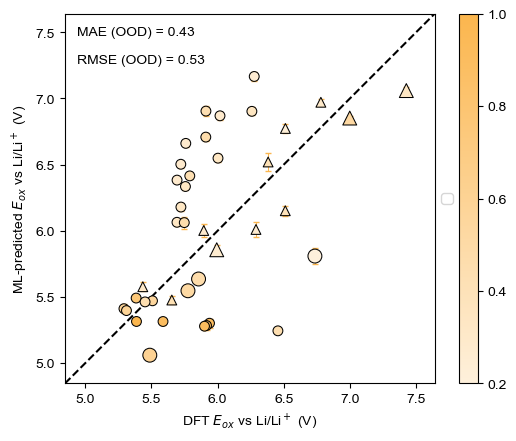

In [10]:
plot_oxstab_parity(df_pred_rand_1, figname=None)

In [11]:
## model-2 without RDKit molecular features with hyperparameters (lower): "depth": 2, "dropout": 0.0, "ffn_hidden_size": 700, "ffn_num_layers": 3, "hidden_size": 700
df_pred_rand_2 = pd.read_csv('random-split/deploy/ood-int-lit/preds_oxstab_ood_final_rand_e1_s400.csv')
df_pred_rand_2['group'] = ['in-house' for i in range(29)] + ['literature' for i in range(29, len(df_pred_rand_1))] ## first 29 are in-house, rest are literature OOD data points
df_pred_rand_2['similarity'] = df_pred_rand_1['similarity']
df_pred_rand_2['most_similar'] = df_pred_rand_1['most_similar']
df_pred_rand_2

,name,smiles,true_IE,class,IE,IE_ensemble_uncal_var,group,similarity,most_similar
0,E2F,FC(F)(F)COCCOCC(F)(F)F,6.259262,Ether,6.613799,0.020212,in-house,0.347826,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F
1,E2F2,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,6.277077,Ether,7.067029,0.013371,in-house,0.259259,C(COCCO)(COCCO)(COCCO)CC
2,E3,CCOCCOCCOCC,5.587656,Ether,5.257498,0.019546,in-house,0.909091,C(COCC)OCC
3,E3F,FC(F)(F)COCCOCCOCC(F)(F)F,6.003231,Ether,6.173225,0.014639,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F
4,E3F2,FC(F)(F)C(F)(F)COCCOCCOCC(F)(F)C(F)(F)F,6.018283,Ether,6.618410,0.006658,in-house,0.285714,COCCOCCOC
5,E4,CCOCCOCCOCCOCC,5.939028,Ether,5.263746,0.023536,in-house,0.909091,C(COCC)OCC
6,E4F,FC(F)(F)COCCOCCOCCOCC(F)(F)F,5.757092,Ether,5.904005,0.011735,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F
7,E4F2,FC(F)(F)C(F)(F)COCCOCCOCCOCC(F)(F)C(F)(F)F,5.759758,Ether,6.299167,0.004404,in-house,0.285714,COCCOCCOC
8,E5,CCOCCOCCOCCOCCOCC,5.916364,Ether,5.278916,0.020307,in-house,0.909091,C(COCC)OCC
9,E5F,FC(F)(F)COCCOCCOCCOCCOCC(F)(F)F,5.722913,Ether,5.723868,0.007701,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F


In [12]:
y_pred = df_pred_rand_2['IE']
y_true = df_pred_rand_2['true_IE']
y_pred_unc = df_pred_rand_2['IE_ensemble_uncal_var']

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
# r2 = r2_score(y_true, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


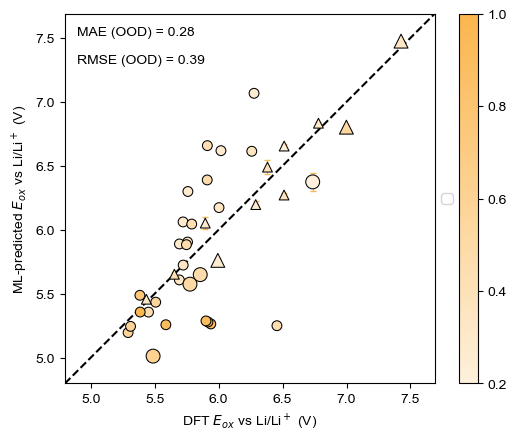

In [13]:
plot_oxstab_parity(df_pred_rand_2, figname=None)

In [8]:
## model-3 with RDKit molecular features & hyperparameters (lower): "depth": 2, "dropout": 0.0, "ffn_hidden_size": 400, "ffn_num_layers": 3, "hidden_size": 400
df_pred_rand_3 = pd.read_csv('random-split/deploy/ood-int-lit/preds_oxstab_ood_final_rand_rd_e3_s400.csv')
df_pred_rand_3['group'] = ['in-house' for i in range(29)] + ['literature' for i in range(29, len(df_pred_rand_1))] ## first 29 are in-house, rest are literature OOD data points
df_pred_rand_3['similarity'] = df_pred_rand_1['similarity']
df_pred_rand_3['most_similar'] = df_pred_rand_1['most_similar']
df_pred_rand_3

,name,smiles,true_IE,class,IE,IE_ensemble_uncal_var,group,similarity,most_similar
0,E2F,FC(F)(F)COCCOCC(F)(F)F,6.259262,Ether,6.217767,0.011198,in-house,0.347826,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F
1,E2F2,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,6.277077,Ether,6.714348,0.019716,in-house,0.259259,C(COCCO)(COCCO)(COCCO)CC
2,E3,CCOCCOCCOCC,5.587656,Ether,5.188294,0.005995,in-house,0.909091,C(COCC)OCC
3,E3F,FC(F)(F)COCCOCCOCC(F)(F)F,6.003231,Ether,5.958901,0.014833,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F
4,E3F2,FC(F)(F)C(F)(F)COCCOCCOCC(F)(F)C(F)(F)F,6.018283,Ether,6.272372,0.013756,in-house,0.285714,COCCOCCOC
5,E4,CCOCCOCCOCCOCC,5.939028,Ether,5.159267,0.010222,in-house,0.909091,C(COCC)OCC
6,E4F,FC(F)(F)COCCOCCOCCOCC(F)(F)F,5.757092,Ether,5.932869,0.012687,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F
7,E4F2,FC(F)(F)C(F)(F)COCCOCCOCCOCC(F)(F)C(F)(F)F,5.759758,Ether,6.150683,0.006880,in-house,0.285714,COCCOCCOC
8,E5,CCOCCOCCOCCOCCOCC,5.916364,Ether,5.156833,0.011160,in-house,0.909091,C(COCC)OCC
9,E5F,FC(F)(F)COCCOCCOCCOCCOCC(F)(F)F,5.722913,Ether,5.924718,0.011137,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F


In [9]:
df_pred_rand_3['error'] = abs(df_pred_rand_3['IE'] - df_pred_rand_3['true_IE'])
df_pred_rand_3['error_sq'] = (df_pred_rand_3['IE'] - df_pred_rand_3['true_IE'])**2
print(np.sqrt(df_pred_rand_3.loc[df_pred_rand_3['similarity'] <= 0.35]['error_sq'].mean()))
# df_pred_rand_3.loc[df_pred_rand_3['similarity'] < 0.3]['error'].mean()

0.2287717770985162


In [48]:
y_pred = df_pred_rand_3['IE']
y_true = df_pred_rand_3['true_IE']
y_pred_unc = df_pred_rand_3['IE_ensemble_uncal_var']

axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


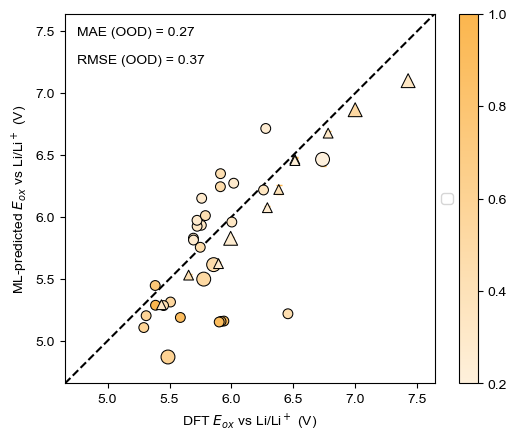

In [50]:
plot_oxstab_parity(df_pred_rand_3, figname='oxstab_parity_ood_final_cdf_rd_rand_cv_comm_s400_e3.eps')

In [ ]:
df_pred_rand_3.to_csv('random-split/deploy/ood-int-lit/preds_oxstab_ood_final_rand_rd_e3_s400.csv', index=False)

In [23]:
# tt_df = pd.read_csv('random-split/deploy/ood-int-lit/preds_ood_int-lit_rand_rd_e3_s400.csv')
# tt_df.drop(index=[0,23,24,26,27], inplace=True)
# tt_df.reset_index(drop=True, inplace=True)
# tt_df['group'] = ['in-house' for i in range(29)] + ['literature' for i in range(29, len(tt_df))] ## first 29 are in-house, rest are literature OOD data points
# tt_df['similarity'] = df_pred_rand_1['similarity']
# tt_df['most_similar'] = df_pred_rand_1['most_similar']
# tt_df['class'] = df_pred_rand_1['class']
# tt_df

,name,smiles,true_IE,IE,IE_ensemble_uncal_var,IE_model_0,IE_model_1,IE_model_2,IE_model_3,IE_model_4,...,IE_model_9,IE_model_10,IE_model_11,IE_model_12,IE_model_13,IE_model_14,group,similarity,most_similar,class
0,E2F,FC(F)(F)COCCOCC(F)(F)F,5.951795,6.217767,0.011198,6.136820,6.092070,6.295029,6.194734,6.099740,...,6.398070,6.237055,6.292914,6.338833,6.066740,6.032937,in-house,0.347826,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F,Ether
1,E2F2,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,6.009504,6.714348,0.019716,6.736020,6.469126,6.869471,6.864314,6.572967,...,6.979466,6.744256,6.729745,6.798135,6.496292,6.567096,in-house,0.259259,C(COCCO)(COCCO)(COCCO)CC,Ether
2,E3,CCOCCOCCOCC,5.290233,5.188294,0.005995,4.992537,5.197494,5.103083,5.191238,5.295563,...,5.212170,5.209493,5.285352,5.169930,5.242370,5.185476,in-house,0.909091,C(COCC)OCC,Ether
3,E3F1,C(COCCOCCOCC(F)(F)F)(F)(F)F,5.666076,5.958901,0.014833,5.915808,5.902393,5.751349,5.965651,5.909949,...,6.082920,6.002686,6.037764,6.203452,5.964082,5.708055,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F,Ether
4,E3F2,C(OCCOCC(C(F)(F)F)(F)F)COCC(C(F)(F)F)(F)F,5.683959,6.272372,0.013756,6.369165,6.053022,6.266447,6.443431,6.157320,...,6.530610,6.274981,6.190133,6.359939,6.192393,6.169747,in-house,0.285714,COCCOCCOC,Ether
5,E4,C(COCCOCCOCC)OCC,5.308823,5.159267,0.010222,4.976684,5.142460,5.025547,5.147502,5.338139,...,5.217240,5.164819,5.207478,5.123138,5.256565,5.092106,in-house,0.909091,C(COCC)OCC,Ether
6,E4F1,C(COCCOCCOCC(F)(F)F)OCC(F)(F)F,5.476410,5.932869,0.012687,5.900654,5.917717,5.723197,5.944663,5.900018,...,6.045207,5.864365,5.990476,6.188634,5.921576,5.788745,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F,Ether
7,E4F2,C(OCCOCCOCC(C(F)(F)F)(F)F)COCC(C(F)(F)F)(F)F,5.545118,6.150683,0.006880,6.274556,6.092646,6.049257,6.214244,6.131580,...,6.308536,6.100624,6.020753,6.193462,6.082790,6.110908,in-house,0.285714,COCCOCCOC,Ether
8,E5,C(COCCOCCOCCOCC)OCC,5.238700,5.156832,0.011160,5.025164,5.109190,5.000329,5.120825,5.347150,...,5.275070,5.150168,5.149148,5.121001,5.239036,5.065213,in-house,0.909091,C(COCC)OCC,Ether
9,E5F1,C(COCCOCCOCCOCC(F)(F)F)OCC(F)(F)F,5.443811,5.924718,0.011137,5.899389,5.901879,5.686082,5.982808,5.920266,...,6.073875,5.876534,5.950071,6.107234,5.895514,5.819450,in-house,0.333333,C(=O)(OCC(F)(F)F)CCC(=O)OCC(F)(F)F,Ether


In [29]:
# y_pred = tt_df['IE']
# y_true = tt_df['true_IE']
# y_pred_unc = tt_df['IE_ensemble_uncal_var']

# axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
# axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))

# mae = mean_absolute_error(y_true, y_pred)
# rmse = mean_squared_error(y_true, y_pred, squared=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


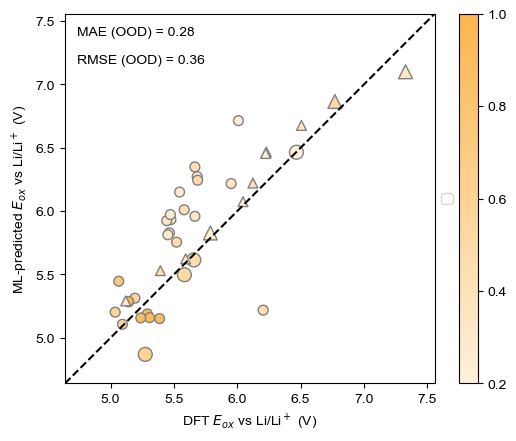

In [25]:
# fig, ax = plt.subplots(1,1)
# plt.plot([axmin, axmax], [axmin, axmax], '--k')

# # Define a dictionary to map groups to markers
# group_marker_dict = {group: marker for group, marker in zip(tt_df['group'].unique(), ['o', '^'])}

# # Define a dictionary to map classes to sizes
# class_size_dict = {cls: size for cls, size in zip(tt_df['class'].unique(), [50, 100])}

# # Define a dictionary to map sizes to edgecolors
# size_edgecolor_dict = {size: edgecolor for size, edgecolor in zip([50, 100], ['black', 'red'])}

# # Create a new column 'marker' in df_true based on the 'group' column
# tt_df['marker'] = tt_df['group'].map(group_marker_dict)

# # Create a new column 'size' in df_true based on the 'class' column
# tt_df['size'] = tt_df['class'].map(class_size_dict)
# tt_df['edgecolor'] = tt_df['size'].map(size_edgecolor_dict)

# # Create the scatter plot
# for group, marker in group_marker_dict.items():
#     df_group = tt_df[tt_df['group'] == group]
#     err = plt.scatter(df_group['true_IE'], tt_df.loc[df_group.index, 'IE'], marker=marker, s=df_group['size'], c=df_group["similarity"], cmap=cmap2, norm=norm2, edgecolors='grey', linewidths=1)

# # Add colorbar, legend, labels, and other elements as before
# fig.colorbar(err, ax=ax, ticks=[0.2, 0.4, 0.6, 0.8, 1.0])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel('DFT $E_{ox}$ vs Li/Li$^+$ (V)')
# plt.ylabel('ML-predicted $E_{ox}$ vs Li/Li$^+$ (V)')
# plt.xlim((axmin, axmax))
# plt.ylim((axmin, axmax))
# ax.set_aspect('equal')
# at = AnchoredText(
# f"MAE (OOD) = {mae:.2f}\n\nRMSE (OOD) = {rmse:.2f}", prop=dict(size=10), frameon=False, loc='upper left')
# ax.add_artist(at)

**Performance using stratified split-II models**

In [30]:
import os, sys
os.getcwd()

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/oxidative-stability_1.1/incl-rdkit-features/hyperparameters_1.1'

In [10]:
## model-4 with RDKit molecular features & hyperparameters (lower): "depth": 2, "dropout": 0.0, "ffn_hidden_size": 400, "ffn_num_layers": 3, "hidden_size": 400
df_pred_strat2_1 = pd.read_csv('./stratified-split-2-cv/deploy/ood-int-lit/preds_oxstab_ood_final_cdf_rd_strat2_e3_s400_2.csv') ## "depth": 2, "dropout": 0.0, "ffn_hidden_size": 700, "ffn_num_layers": 3, "hidden_size": 400
df_pred_strat2_1['group'] = ['in-house' for i in range(29)] + ['literature' for i in range(29, len(df_pred_strat2_1))] ## first 31 are in-house, rest are literature OOD data points
df_pred_strat2_1

,name,smiles,true_IE,class,IE,IE_ensemble_uncal_var,group
0,E2F,FC(F)(F)COCCOCC(F)(F)F,6.259262,Ether,6.351062,0.037258,in-house
1,E2F2,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,6.277077,Ether,6.804077,0.032563,in-house
2,E3,CCOCCOCCOCC,5.587656,Ether,5.152496,0.014247,in-house
3,E3F,FC(F)(F)COCCOCCOCC(F)(F)F,6.003231,Ether,6.069011,0.029039,in-house
4,E3F2,FC(F)(F)C(F)(F)COCCOCCOCC(F)(F)C(F)(F)F,6.018283,Ether,6.363967,0.035463,in-house
5,E4,CCOCCOCCOCCOCC,5.939028,Ether,5.123842,0.018390,in-house
6,E4F,FC(F)(F)COCCOCCOCCOCC(F)(F)F,5.757092,Ether,6.005744,0.024819,in-house
7,E4F2,FC(F)(F)C(F)(F)COCCOCCOCCOCC(F)(F)C(F)(F)F,5.759758,Ether,6.219742,0.024675,in-house
8,E5,CCOCCOCCOCCOCCOCC,5.916364,Ether,5.125273,0.018691,in-house
9,E5F,FC(F)(F)COCCOCCOCCOCCOCC(F)(F)F,5.722913,Ether,5.961029,0.019664,in-house


In [11]:
df_ref = pd.read_csv('./stratified-split-2-cv/train_strat.csv') ## stratified split train set
ref = df_ref['smiles']
ref_mol = [Chem.MolFromSmiles(sm) for sm in ref]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

similarity_list = []
similar_smiles = []
for i in range(len(df_pred_strat2_1)):
    sm = df_pred_strat2_1['smiles'][i]
    max_similarity, ind, sim_smile = check_similarity(sm)
    # print(sm, max_similarity, sim_smile)
    similarity_list.append(max_similarity)
    similar_smiles.append(sim_smile)

df_pred_strat2_1['similarity'] = similarity_list
df_pred_strat2_1['most_similar'] = similar_smiles
df_pred_strat2_1

,name,smiles,true_IE,class,IE,IE_ensemble_uncal_var,group,similarity,most_similar
0,E2F,FC(F)(F)COCCOCC(F)(F)F,6.259262,Ether,6.351062,0.037258,in-house,0.421053,B(OCC(F)(F)F)(OCC(F)(F)F)OCC(F)(F)F
1,E2F2,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,6.277077,Ether,6.804077,0.032563,in-house,0.260870,B(OCC(F)(F)F)(OCC(F)(F)F)OCC(F)(F)F
2,E3,CCOCCOCCOCC,5.587656,Ether,5.152496,0.014247,in-house,0.909091,C(COCC)OCC
3,E3F,FC(F)(F)COCCOCCOCC(F)(F)F,6.003231,Ether,6.069011,0.029039,in-house,0.400000,B(OCC(F)(F)F)(OCC(F)(F)F)OCC(F)(F)F
4,E3F2,FC(F)(F)C(F)(F)COCCOCCOCC(F)(F)C(F)(F)F,6.018283,Ether,6.363967,0.035463,in-house,0.285714,O(CCOCCO)CCOCCO
5,E4,CCOCCOCCOCCOCC,5.939028,Ether,5.123842,0.018390,in-house,0.909091,C(COCC)OCC
6,E4F,FC(F)(F)COCCOCCOCCOCC(F)(F)F,5.757092,Ether,6.005744,0.024819,in-house,0.400000,B(OCC(F)(F)F)(OCC(F)(F)F)OCC(F)(F)F
7,E4F2,FC(F)(F)C(F)(F)COCCOCCOCCOCC(F)(F)C(F)(F)F,5.759758,Ether,6.219742,0.024675,in-house,0.285714,O(CCOCCO)CCOCCO
8,E5,CCOCCOCCOCCOCCOCC,5.916364,Ether,5.125273,0.018691,in-house,0.909091,C(COCC)OCC
9,E5F,FC(F)(F)COCCOCCOCCOCCOCC(F)(F)F,5.722913,Ether,5.961029,0.019664,in-house,0.400000,B(OCC(F)(F)F)(OCC(F)(F)F)OCC(F)(F)F


In [12]:
y_pred = df_pred_strat2_1['IE']
y_true = df_pred_strat2_1['true_IE']
y_pred_unc = df_pred_strat2_1['IE_ensemble_uncal_var']

axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
# r2 = r2_score(y_true, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


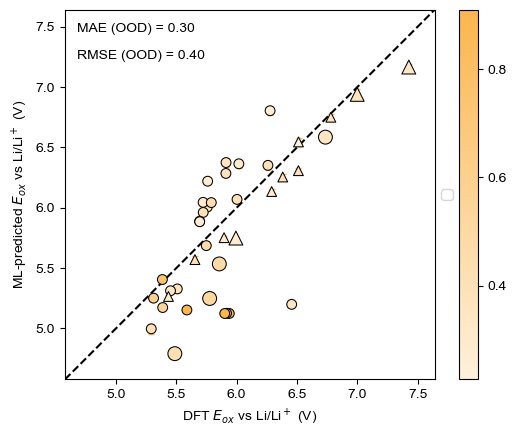

In [36]:
plot_oxstab_parity(df_pred_strat2_1, figname=None)

In [13]:
df_pred_strat2_1['error'] = abs(df_pred_strat2_1['IE'] - df_pred_strat2_1['true_IE'])
df_pred_strat2_1['error_sq'] = (df_pred_strat2_1['IE'] - df_pred_strat2_1['true_IE'])**2
print(np.sqrt(df_pred_strat2_1.loc[df_pred_strat2_1['similarity'] <= 0.35]['error_sq'].mean()))
# df_pred_strat2_1.sort_values(ascending=False, by='error')

0.27659864845730453


In [49]:
%%bash
pwd

/home/ritesh/ExpanDrive/Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/oxidative-stability_1.1/incl-rdkit-features/hyperparameters_1.1


**Performance using stratified split-I model**

In [38]:
# df_pred_strat1 = pd.read_csv('./stratified-split-1/deploy/ood-int-lit/preds_oxstab_ood_final_strat1_e3_s400.csv') ## "depth": 2, "dropout": 0.0, "ffn_hidden_size": 700, "ffn_num_layers": 3, "hidden_size": 400
df_pred_strat1 = pd.read_csv('./stratified-split-1/deploy/ood-int-lit/preds_oxstab_ood_final_strat1_rd_e3_s400.csv')
df_pred_strat1['group'] = ['in-house' for i in range(29)] + ['literature' for i in range(29, len(df_pred_strat1))] ## first 31 are in-house, rest are literature OOD data points
df_pred_strat1

,name,smiles,true_IE,class,IE,IE_ensemble_uncal_var,group
0,E2F,FC(F)(F)COCCOCC(F)(F)F,6.259262,Ether,5.327283,0.035766,in-house
1,E2F2,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,6.277077,Ether,5.273957,0.052883,in-house
2,E3,CCOCCOCCOCC,5.587656,Ether,4.914185,0.037640,in-house
3,E3F,FC(F)(F)COCCOCCOCC(F)(F)F,6.003231,Ether,5.267114,0.028006,in-house
4,E3F2,FC(F)(F)C(F)(F)COCCOCCOCC(F)(F)C(F)(F)F,6.018283,Ether,5.117819,0.043682,in-house
5,E4,CCOCCOCCOCCOCC,5.939028,Ether,4.877345,0.037990,in-house
6,E4F,FC(F)(F)COCCOCCOCCOCC(F)(F)F,5.757092,Ether,5.242273,0.030299,in-house
7,E4F2,FC(F)(F)C(F)(F)COCCOCCOCCOCC(F)(F)C(F)(F)F,5.759758,Ether,5.150022,0.041594,in-house
8,E5,CCOCCOCCOCCOCCOCC,5.916364,Ether,4.842359,0.039760,in-house
9,E5F,FC(F)(F)COCCOCCOCCOCCOCC(F)(F)F,5.722913,Ether,5.184888,0.033222,in-house


In [40]:
df_ref = pd.read_csv('./stratified-split-1/train_strat1.csv')
ref = df_ref['smiles'] ## stratified split train set
ref_mol = [Chem.MolFromSmiles(sm) for sm in ref]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

similarity_list = []
similar_smiles = []
for i in range(len(df_pred_strat1)):
    sm = df_pred_strat1['smiles'][i]
    max_similarity, ind, sim_smile = check_similarity(sm)
    # print(sm, max_similarity, sim_smile)
    similarity_list.append(max_similarity)
    similar_smiles.append(sim_smile)

df_pred_strat1['similarity'] = similarity_list
df_pred_strat1['most_similar'] = similar_smiles
df_pred_strat1

,name,smiles,true_IE,class,IE,IE_ensemble_uncal_var,group,similarity,most_similar
0,E2F,FC(F)(F)COCCOCC(F)(F)F,6.259262,Ether,5.327283,0.035766,in-house,0.277778,C(COCC)OCC
1,E2F2,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,6.277077,Ether,5.273957,0.052883,in-house,0.250000,C(COCC)OCC
2,E3,CCOCCOCCOCC,5.587656,Ether,4.914185,0.037640,in-house,0.909091,C(COCC)OCC
3,E3F,FC(F)(F)COCCOCCOCC(F)(F)F,6.003231,Ether,5.267114,0.028006,in-house,0.285714,C(COCCCC)OCCCC
4,E3F2,FC(F)(F)C(F)(F)COCCOCCOCC(F)(F)C(F)(F)F,6.018283,Ether,5.117819,0.043682,in-house,0.260870,C(COCCCC)OCCCC
5,E4,CCOCCOCCOCCOCC,5.939028,Ether,4.877345,0.037990,in-house,0.909091,C(COCC)OCC
6,E4F,FC(F)(F)COCCOCCOCCOCC(F)(F)F,5.757092,Ether,5.242273,0.030299,in-house,0.285714,C(COCCCC)OCCCC
7,E4F2,FC(F)(F)C(F)(F)COCCOCCOCCOCC(F)(F)C(F)(F)F,5.759758,Ether,5.150022,0.041594,in-house,0.260870,C(COCCCC)OCCCC
8,E5,CCOCCOCCOCCOCCOCC,5.916364,Ether,4.842359,0.039760,in-house,0.909091,C(COCC)OCC
9,E5F,FC(F)(F)COCCOCCOCCOCCOCC(F)(F)F,5.722913,Ether,5.184888,0.033222,in-house,0.285714,C(COCCCC)OCCCC


In [41]:
y_pred = df_pred_strat1['IE']
y_true = df_pred_strat1['true_IE']
y_pred_unc = df_pred_strat1['IE_ensemble_uncal_var']

axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


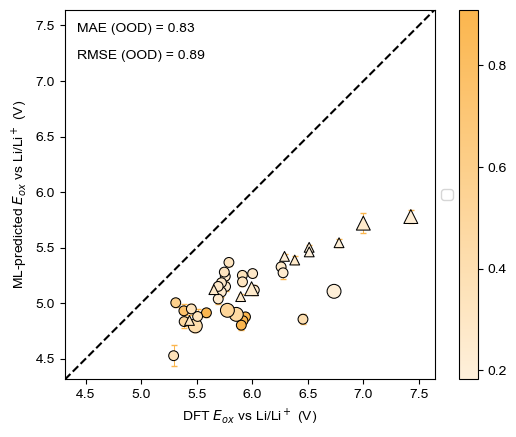

In [42]:
plot_oxstab_parity(df_pred_strat1, figname=None)

**Performance using scaffold split model**

In [43]:
df_pred_scaff = pd.read_csv('scaffold-split/deploy/ood-int-lit/preds_oxstab_ood_final_scaff_rd_e3_s400.csv') ## "depth": 2, "dropout": 0.0, "ffn_hidden_size": 700, "ffn_num_layers": 3, "hidden_size": 400
df_pred_scaff['group'] = ['in-house' for i in range(29)] + ['literature' for i in range(29, len(df_pred_scaff))] ## first 31 are in-house, rest are literature OOD data points
df_pred_scaff

,name,smiles,true_IE,class,IE,IE_ensemble_uncal_var,group
0,E2F,FC(F)(F)COCCOCC(F)(F)F,6.259262,Ether,6.012892,0.016885,in-house
1,E2F2,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,6.277077,Ether,6.258166,0.028401,in-house
2,E3,CCOCCOCCOCC,5.587656,Ether,5.246665,0.019227,in-house
3,E3F,FC(F)(F)COCCOCCOCC(F)(F)F,6.003231,Ether,5.931346,0.018211,in-house
4,E3F2,FC(F)(F)C(F)(F)COCCOCCOCC(F)(F)C(F)(F)F,6.018283,Ether,6.049108,0.025232,in-house
5,E4,CCOCCOCCOCCOCC,5.939028,Ether,5.203362,0.021447,in-house
6,E4F,FC(F)(F)COCCOCCOCCOCC(F)(F)F,5.757092,Ether,5.991180,0.028386,in-house
7,E4F2,FC(F)(F)C(F)(F)COCCOCCOCCOCC(F)(F)C(F)(F)F,5.759758,Ether,6.074737,0.028396,in-house
8,E5,CCOCCOCCOCCOCCOCC,5.916364,Ether,5.163259,0.018190,in-house
9,E5F,FC(F)(F)COCCOCCOCCOCCOCC(F)(F)F,5.722913,Ether,5.973864,0.031870,in-house


In [45]:
df_ref = pd.read_csv('./scaffold-split/train_scaffold.csv')
ref = df_ref['smiles'] ## scaffold split train set
ref_mol = [Chem.MolFromSmiles(sm) for sm in ref]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

similarity_list = []
similar_smiles = []
for i in range(len(df_pred_scaff)):
    sm = df_pred_scaff['smiles'][i]
    max_similarity, ind, sim_smile = check_similarity(sm)
    # print(sm, max_similarity, sim_smile)
    similarity_list.append(max_similarity)
    similar_smiles.append(sim_smile)

df_pred_scaff['similarity'] = similarity_list
df_pred_scaff['most_similar'] = similar_smiles
df_pred_scaff

,name,smiles,true_IE,class,IE,IE_ensemble_uncal_var,group,similarity,most_similar
0,E2F,FC(F)(F)COCCOCC(F)(F)F,6.259262,Ether,6.012892,0.016885,in-house,0.264706,COCCOCCOCCOc1c(C(F)(F)F)nccn1
1,E2F2,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,6.277077,Ether,6.258166,0.028401,in-house,0.216216,COCCOCCOCCOc1c(C(F)(F)F)nccn1
2,E3,CCOCCOCCOCC,5.587656,Ether,5.246665,0.019227,in-house,0.269231,COCCOCCOc1c(nccn1)OCCOC
3,E3F,FC(F)(F)COCCOCCOCC(F)(F)F,6.003231,Ether,5.931346,0.018211,in-house,0.294118,COCCOCCOCCOc1c(C(F)(F)F)nccn1
4,E3F2,FC(F)(F)C(F)(F)COCCOCCOCC(F)(F)C(F)(F)F,6.018283,Ether,6.049108,0.025232,in-house,0.243243,COCCOCCOCCOc1c(C(F)(F)F)nccn1
5,E4,CCOCCOCCOCCOCC,5.939028,Ether,5.203362,0.021447,in-house,0.269231,COCCOCCOc1c(nccn1)OCCOC
6,E4F,FC(F)(F)COCCOCCOCCOCC(F)(F)F,5.757092,Ether,5.991180,0.028386,in-house,0.294118,COCCOCCOCCOc1c(C(F)(F)F)nccn1
7,E4F2,FC(F)(F)C(F)(F)COCCOCCOCCOCC(F)(F)C(F)(F)F,5.759758,Ether,6.074737,0.028396,in-house,0.243243,COCCOCCOCCOc1c(C(F)(F)F)nccn1
8,E5,CCOCCOCCOCCOCCOCC,5.916364,Ether,5.163259,0.018190,in-house,0.269231,COCCOCCOc1c(nccn1)OCCOC
9,E5F,FC(F)(F)COCCOCCOCCOCCOCC(F)(F)F,5.722913,Ether,5.973864,0.031870,in-house,0.294118,COCCOCCOCCOc1c(C(F)(F)F)nccn1


In [46]:
y_pred = df_pred_scaff['IE']
y_true = df_pred_scaff['true_IE']
y_pred_unc = df_pred_scaff['IE_ensemble_uncal_var']

axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


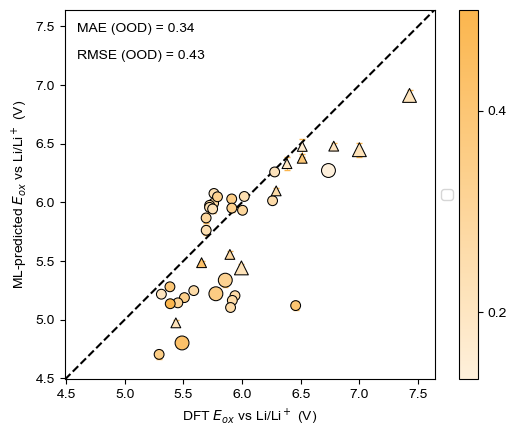

In [47]:
plot_oxstab_parity(df_pred_scaff, figname=None)